The goal of this exercise is to implement the backpropagation algorithm for neural networks and use it for hand-written digit recognition.

In the X.csv file there are 5000 training examples that are 20x20 grayscale images of the hand-written digits (from the MNIST database). Each 20x20 image has been unrolled into a 400 dimensional vector and became a row in the 5000x400 matrix X. In the y.csv file there is a 5000 dimensional vector of labels for the training set.

I start by reading the data and visualising it.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.genfromtxt('X.csv', delimiter=',')
y = np.genfromtxt('y.csv', delimiter=',')

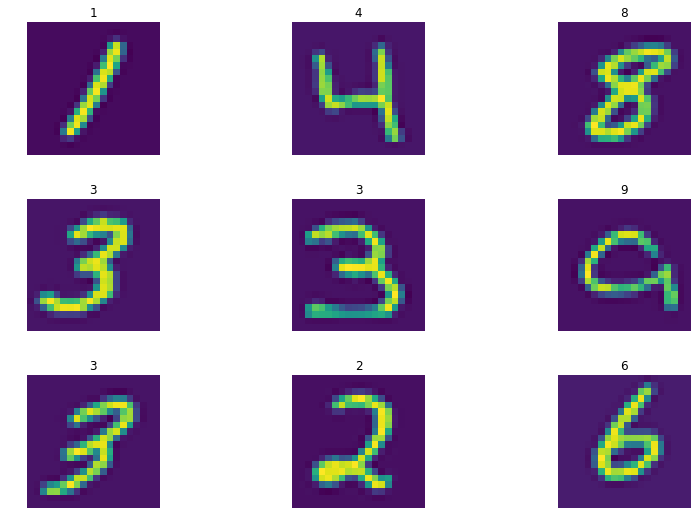

In [42]:
from random import sample
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols)
indexes = sample(range(0, X.shape[0]), rows*cols)
indexes = np.reshape(indexes, (rows, cols))
fig.set_size_inches(12, 7.5)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X[indexes[i, j]].reshape(20, 20, order='F'))
        ax[i, j].axis('off')
        ax[i, j].set_title(int(y[indexes[i, j]]))
plt.tight_layout()

Neural network used in the exercise will be a very simple one comprising 3 layers - an input layer, a hidden layer and an output layer. Inputs are pixel values of a 20x20 pixel image, so there will be 400 input units and 1 bias unit. I already have a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ provided by a course lecturer. The second layer has 25 units and the output layer has 10 output units (because there are 10 digits 0-9). Hence $\Theta^{(1)}$ is 25x401 dimensional and $\Theta^{(2)}$ is 10x26 dimensional.

In [3]:
Theta1 = np.genfromtxt('Theta1.csv', delimiter=',')
Theta2 = np.genfromtxt('Theta2.csv', delimiter=',')
[Theta1.shape, Theta2.shape]

[(25, 401), (10, 26)]

Next I will implement feedforward propagation and the cost function. The cost function for the neural network (without regularisation) is: $J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{j=1}^K [-y_k^{(i)} log((h_\theta(x^{(i)}))_k) - (1 - y_k^{(i)}) log(1 - (h_\theta(x^{(i)}))_k)]$.

In [4]:
# Appending column of ones at the beginning of X matrix to take bias units into account.
X = np.insert(X, 0, 1, axis=1)
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

I will have to recode $y$ so the labels are vectors containing only 0 or 1. For example when $y^{(i)} = 5$ then $y^{(i)} = [0, 0, 0, 0, 1, 0, 0, 0, 0]$. I will recode $y$ to be a matrix $Y$ containg each label in a row.

In [5]:
Y = np.zeros((len(y), 10))
for index, row in enumerate(Y):
    row[int(y[index])] = 1
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
from numbers import Number
def sigmoid(x):
    if isinstance(x, Number):
        return 1/(1+np.exp(-x))
    else:
        return np.divide(np.ones(x.shape), np.add(np.ones(x.shape), np.exp(np.negative(x))))

def sigmoid_gradient(x):
    if isinstance(x, Number):
        return sigmoid(x)*(1 - sigmoid(x))
    else:
        return np.multiply(sigmoid(x), (np.subtract(np.ones(x.shape), sigmoid(x))))

In [7]:
def nn_cost_function_matlab_indexing(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, regularisation_parameter):
    '''
    This function takes into account the fact that neural network\'s Theta1 and Theta2 parameters
    supplied by a course lecturer have been derived in MATLAB where array indexing is different than
    in Python and my model. So in order for it to calculate correct values I have to change the order
    of columns in Htheta - the last column should become the first.
    '''
    Theta1 = np.reshape(theta[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(theta[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), order='F')
    m = X.shape[0]
    K = Y.shape[1]
    # Feedforward.
    z2 = (Theta1 @ np.transpose(X)) # Now every column contains a transformed training example.
    a2 = sigmoid(z2)
    # Appending a row of ones to take bias into account.
    a2 = np.insert(a2, 0, 1, axis=0)
    z3 = np.transpose(Theta2 @ a2) # Now every row contains an output value.
    Htheta = sigmoid(z3) # Every row contains a hypothesis value.
    # Have to change the last row with the first one because of different indexing in MATLAB.
    Htheta = np.insert(Htheta, 0, Htheta[:, -1], axis=1) # 1
    Htheta = np.delete(Htheta, 10, axis=1) # 2
    #
    # Cost function.
    J = 1/m * sum(sum(np.subtract(np.multiply(-Y, np.log(Htheta)), np.multiply(np.subtract(np.ones(Y.shape), Y), np.log(np.subtract(np.ones(Y.shape), Htheta))))))
    J += regularisation_parameter/(2*m) * (sum(sum(np.square(Theta1))) + sum(sum(np.square(Theta2))))
    return J
#[nn_cost_function_matlab_indexing(Theta1, Theta2, X, Y, 0), nn_cost_function_matlab_indexing(Theta1, Theta2, X, Y, 1)]
theta = np.concatenate((Theta1.T.ravel(), Theta2.T.ravel()))
[nn_cost_function_matlab_indexing(theta, 400, 25, 10, X, Y, 0),\
 nn_cost_function_matlab_indexing(theta, 400, 25, 10, X, Y, 1)]

[0.28762916516131876, 0.3844877962428938]

Computed values are correct (they were compared with values provided in the exercise description). I had to take into account MATLAB's array indexing.

In [8]:
def nn_cost_function1(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, regularisation_parameter):
    '''
    This function should work for Python indexing.
    '''
    Theta1 = np.reshape(theta[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(theta[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), order='F')
    m = X.shape[0]
    K = Y.shape[1]
    # Feedforward.
    z2 = (Theta1 @ np.transpose(X)) # Now every column contains a transformed training example.
    a2 = sigmoid(z2)
    # Appending a row of ones to take bias into account.
    a2 = np.insert(a2, 0, 1, axis=0)
    z3 = np.transpose(Theta2 @ a2) # Now every row contains an output value.
    Htheta = sigmoid(z3) # Every row contains a hypothesis value.
    # Cost function.
    J = 1/m * sum(sum(np.subtract(np.multiply(-Y, np.log(Htheta)), np.multiply(np.subtract(np.ones(Y.shape), Y), np.log(np.subtract(np.ones(Y.shape), Htheta))))))
    J += regularisation_parameter/(2*m) * (sum(sum(np.square(Theta1))) + sum(sum(np.square(Theta2))))
    return J

When training neural networks it is important to randomly initialize the weights for the purpouses of symmetry breaking. Proposed strategy is to select random values for $\Theta^{(l)}$ uniformly from the range $[-\epsilon_{init}, \epsilon_{init}]$. It is advised to choose $\epsilon_{init}$ based on the number of units in layers adjacent to the weights according to the formula: $\frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$.

In [9]:
Lin = 401
Lout = 25
eps_init = np.sqrt(6)/np.sqrt(Lin + Lout)
eps_init

0.11867816581938531

In this case $\epsilon_{init} \approx 0.12$.

In [10]:
MyTheta1 = np.random.uniform(-eps_init, eps_init, (25, 401))

And now for $\Theta^{(2)}$.

In [11]:
Lin = 26
Lout = 10
eps_init = np.sqrt(6)/np.sqrt(Lin + Lout)
eps_init

0.40824829046386296

In [12]:
MyTheta2 = np.random.uniform(-eps_init, eps_init, (10, 26))

Now I can implement backpropagation.

In [13]:
def nn_cost_function2(theta, input_layer_size, hidden_layer_size, num_labels, X, Y, regularisation_parameter):
    '''
    This function should work for Python indexing.
    '''
    Theta1 = np.reshape(theta[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(theta[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), order='F')
    m = X.shape[0]
    K = Y.shape[1]
    # Feedforward.
    z2 = (Theta1 @ np.transpose(X)) # Now every column contains a transformed training example.
    a2 = sigmoid(z2)
    # Appending a row of ones to take bias into account.
    a2 = np.insert(a2, 0, 1, axis=0)
    z3 = np.transpose(Theta2 @ a2) # Now every row contains an output value.
    Htheta = sigmoid(z3) # Every row contains a hypothesis value.
    # Cost function.
    J = 1/m * sum(sum(np.subtract(np.multiply(-Y, np.log(Htheta)), np.multiply(np.subtract(np.ones(Y.shape), Y), np.log(np.subtract(np.ones(Y.shape), Htheta))))))
    J += regularisation_parameter/(2*m) * (sum(sum(np.square(Theta1))) + sum(sum(np.square(Theta2))))
    # Backpropagation.
    a3 = np.copy(Htheta)
    delta3 = np.subtract(a3, Y)
    delta2 = np.multiply(np.transpose(Theta2) @ np.transpose(delta3), sigmoid_gradient(np.insert(z2, 0, 1, axis=0)))
    # Removing "error term" coming from bias term.
    delta2 = np.delete(delta2, 0, axis=0) # Now every column contains "error term" for layer 2. 
    DELTA2 = np.transpose(delta3)@np.transpose(a2)
    DELTA1 = delta2@X
    D1 = DELTA1/m
    D2 = DELTA2/m
    # Regularisation
    Theta12 = np.copy(Theta1)
    Theta12[:, 0] = 0
    D1 = np.add(D1, regularisation_parameter/m * Theta12)
    Theta22 = np.copy(Theta2)
    Theta22[:, 0] = 0
    D2 = np.add(D2, regularisation_parameter/m * Theta22)
    # Unrolling gradients.
    grad = np.concatenate((D1.T.ravel(), D2.T.ravel()))
    return [J, grad]
mytheta = np.concatenate((MyTheta1.T.ravel(), MyTheta2.T.ravel()))
Jval, grad = nn_cost_function2(mytheta, 400, 25, 10, X, Y, 0)
[Jval, grad]

[7.976046721237523,
 array([-0.16864661,  0.05511215, -0.00396877, ...,  0.19586927,
         0.35798085,  0.2797279 ])]

Now in order to check if my backpropagation implementation is correct I will perform gradient checking using gradient values computed numerically.

In [196]:
cost_function = lambda p: nn_cost_function1(p, 400, 25, 10, X, Y, 0)
def compute_numerical_gradient(cost_function, theta):
    numgrad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    e = 1e-4
    for index, p in enumerate(range(theta.size)):
        perturb[index] = e;
        loss1 = cost_function(np.subtract(theta, perturb))
        loss2 = cost_function(np.add(theta, perturb))
        numgrad[index] = (loss2 - loss1) / (2*e)
        perturb[index] = 0
    return numgrad
numerical_gradient = compute_numerical_gradient(cost_function, mytheta) #unregularised

In [198]:
diff = np.linalg.norm(np.subtract(numerical_gradient, grad))/np.linalg.norm(np.add(numerical_gradient, grad))
diff

3.264565138064996e-10

Relative difference between numerically computed gradient and derived analytically from backpropagation is smaller than 1e-9 so I have strong evidence that my implementation of backpropagation is correct.

In [14]:
reg_Jval, reg_grad = nn_cost_function2(mytheta, 400, 25, 10, X, Y, 1)
[reg_Jval, reg_grad]

[7.982204326925314,
 array([-0.16864661,  0.05511215, -0.00396877, ...,  0.19594647,
         0.35801755,  0.27965109])]

In [221]:
cost_function = lambda p: nn_cost_function1(p, 400, 25, 10, X, Y, 1)
reg_numerical_gradient = compute_numerical_gradient(cost_function, mytheta)
diff = np.linalg.norm(np.subtract(reg_numerical_gradient, reg_grad))/np.linalg.norm(np.add(reg_numerical_gradient, reg_grad))
diff

2.3903877655565138e-05

Again the difference is very small so I am more confident in my implementation. Now I can train the neural network using SciPy's fmin_cg function.

In [15]:
from scipy import optimize
regularisation_parameter = 1
optimal_theta = optimize.fmin_cg(f=lambda x: nn_cost_function2(x, 400, 25, 10, X, Y, regularisation_parameter)[0],
                                 x0=mytheta,
                                 fprime=lambda x: nn_cost_function2(x, 400, 25, 10, X, Y, regularisation_parameter)[1])


         Current function value: 0.342184
         Iterations: 171
         Function evaluations: 490
         Gradient evaluations: 478


In [16]:
nn_cost_function2(optimal_theta, 400, 25, 10, X, Y, 1)

[0.3421839601437344,
 array([-3.02528078e-04, -4.20447617e-04,  8.62092543e-04, ...,
         6.80948737e-05,  5.86870478e-05,  2.12824568e-04])]

In [17]:
def predict(theta, input_layer_size, hidden_layer_size, num_labels, X):
    Theta1 = np.reshape(theta[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(theta[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), order='F')
    m = X.shape[0]
    K = Y.shape[1]
    # Feedforward.
    z2 = (Theta1 @ np.transpose(X)) # Now every column contains a transformed training example.
    a2 = sigmoid(z2)
    # Appending a row of ones to take bias into account.
    a2 = np.insert(a2, 0, 1, axis=0)
    z3 = np.transpose(Theta2 @ a2) # Now every row contains an output value.
    Htheta = sigmoid(z3) # Every row contains a hypothesis value.
    return Htheta

predictions = np.argmax(predict(optimal_theta, 400, 25, 10, X), axis=1)
predictions

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [18]:
sum(predictions == y)/len(y)*100

99.16

My neural network predicts 99.16% of exampels in training sets correctly. Now I am curious which examples were classified incorrectly.

[[1440 4251 2498]
 [1413 1550  561]
 [4593 4990 2593]]


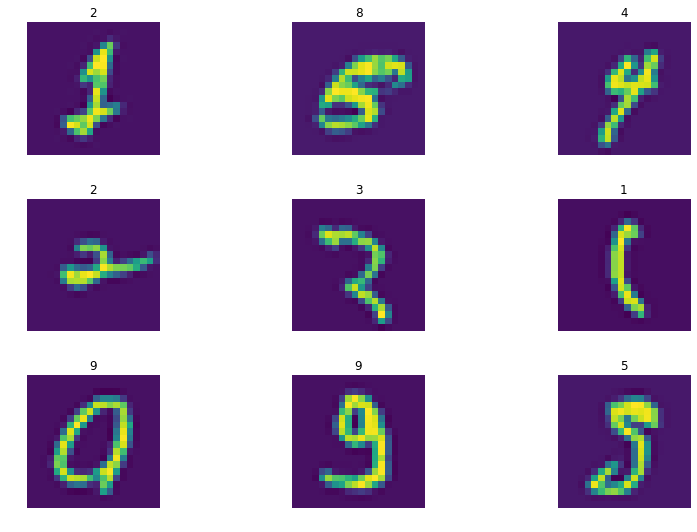

In [43]:
incorrectly_classified = [i for i in range(len(y)) if predictions[i] != y[i]]
X2 = np.genfromtxt('X.csv', delimiter=',')
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols)
indexes = sample(incorrectly_classified, rows*cols)
indexes = np.reshape(indexes, (rows, cols))
fig.set_size_inches(12, 7.5)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X2[indexes[i, j]].reshape(20, 20, order='F'))
        ax[i, j].axis('off')
        ax[i, j].set_title(int(y[indexes[i, j]]))
plt.tight_layout()
print(indexes)

It is noticeable that some of those incorrectly classified examples are really badly written.

Now I will visualise what activates hidden units.

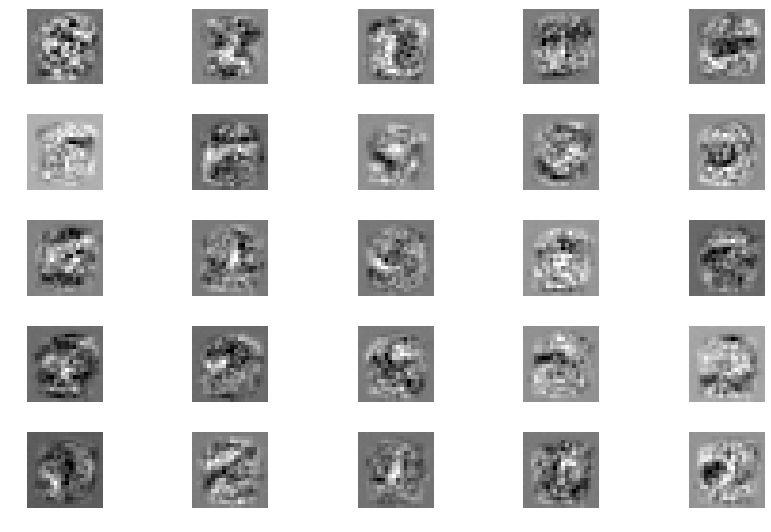

In [35]:
optimal_Theta1 = np.reshape(optimal_theta[:25*(400+1)], (25, 400+1), order='F')
optimal_Theta1 = optimal_Theta1[:, 1:]

rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(12, 7.5)
indexes = list(range(rows*cols))
indexes = np.reshape(indexes, (rows, cols))
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(optimal_Theta1[indexes[i, j]].reshape(20, 20, order='F'), cmap='gray')
        ax[i, j].axis('off')
plt.tight_layout()